In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# At this point:
# Date is read correctly
# Other columns are auto-named as "Unnamed"

In [6]:
# ============================================================
# CONFIG: run TWO pipelines side-by-side (SPY and AAPL)
# ------------------------------------------------------------
# We do NOT merge SPY and AAPL together.
# We clean each one separately and save separate outputs.
# ============================================================

from pathlib import Path

DATA_DIR = Path("../data")

CONFIGS = {
    # ---- MAIN dataset (supports 2010-2023 splits) ----
    "SPY": {
        "options_path": DATA_DIR / "SPY_Options.csv",          # <-- change if your filename differs
        "daily_path":   DATA_DIR / "SPY_daily.csv",            # <-- your Yahoo-style daily file
        "out_options_clean": DATA_DIR / "options_clean_SPY.csv",
        "out_daily_clean":   DATA_DIR / "daily_clean_SPY.csv",
    },

    # ---- Secondary dataset (AAPL options are split into 2 files) ----
    "AAPL": {
        "options_path_1": DATA_DIR / "aapl_2016_2020.csv",      # <-- change if your filename differs
        "options_path_2": DATA_DIR / "aapl_2021_2023.csv",
        "daily_path":     DATA_DIR / "AAPL_daily.csv",          # <-- you must have daily prices for the same period
        "out_options_clean": DATA_DIR / "options_clean_AAPL.csv",
        "out_daily_clean":   DATA_DIR / "daily_clean_AAPL.csv",
    },
}

# ============================================================
# Helper: robust Yahoo CSV reader
# ------------------------------------------------------------
# Some Yahoo CSV exports include extra header rows like:
# "Price,Close,High,Low,Open,Volume"
# "Ticker,SPY,SPY,SPY,SPY,SPY"
# then "Date,Close,High,..."
#
# This finds the row that contains "Date" and uses it as header.
# ============================================================

def read_yahoo_daily_csv(path):
    """
    Robust reader for Yahoo-style CSVs that have:
    Row 0: Price, Close, High, ...
    Row 1: Ticker, SPY/AAPL, SPY/AAPL, ...
    Row 2: Date, Close, High, Low, Open, Volume
    """
    path = Path(path)

    # Read first 5 rows to detect where "Date" really is
    preview = pd.read_csv(path, header=None, nrows=5)

    header_row = None
    for i in range(len(preview)):
        if "Date" in preview.iloc[i].values:
            header_row = i
            break

    if header_row is None:
        raise ValueError(f"Could not find Date header in {path}")

    df = pd.read_csv(path, header=header_row)
    
    # If first column is NOT Date values, fix shifted header problem
    if df.columns[0] != "Date":
        df = pd.read_csv(
            path,
            header=header_row,
            index_col=False
        )
    
    # Force correct column names when Yahoo shifts them
    expected = ["Date", "Close", "High", "Low", "Open", "Volume"]
    if len(df.columns) >= 6:
        df = df.iloc[:, :6]
        df.columns = expected
    
    # Final cleanup
    df.columns = [str(c).strip() for c in df.columns]
    
    return df

In [7]:
# ============================================================
# Clean DAILY price data (SPY and AAPL separately)
# ------------------------------------------------------------
# Output (per asset):
# - daily_clean_<ASSET>.csv
# Columns:
#   Date, Close, High, Low, Open, Volume
# ============================================================

daily_clean = {}

for asset, cfg in CONFIGS.items():
    df = read_yahoo_daily_csv(cfg["daily_path"])

    # ---- parse dates ----
    df["Date"] = pd.to_datetime(df["Date"], format="mixed", dayfirst=False, errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)
    
    # ---- standardize OHLCV column names ----
    cols = {c.lower(): c for c in df.columns}
    
    if "close" not in cols and "adj close" in cols:
        df = df.rename(columns={cols["adj close"]: "Close"})
    
    keep = []
    for name in ["Date", "Close", "High", "Low", "Open", "Volume"]:
        if name in df.columns:
            keep.append(name)
    
    df = df[keep].copy()


    # ---- basic sanity checks ----
    assert "Date" in df.columns
    assert "Close" in df.columns

    daily_clean[asset] = df
    df.to_csv(cfg["out_daily_clean"], index=False)

    print(f"[{asset}] daily rows: {len(df):,} | Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")

[SPY] daily rows: 3,522 | Date range: 2010-01-04 → 2023-12-29
[AAPL] daily rows: 2,012 | Date range: 2016-01-04 → 2023-12-29


In [10]:
# ============================================================
# Clean OPTIONS data (SPY and AAPL separately)
# ------------------------------------------------------------
# Goal output columns (minimal but sufficient for later notebooks):
# QUOTE_DATE, EXPIRE_DATE, DTE, UNDERLYING_LAST, STRIKE,
# C_BID, C_ASK, P_BID, P_ASK, C_MID, P_MID, MONEINESS
# ============================================================

def clean_options_df(df):
    # --------------------------------------------------
    # Standardize column names
    # --------------------------------------------------
    df.columns = (
        df.columns
          .astype(str)
          .str.strip()
          .str.strip("[]")   # ← THIS IS THE KEY FIX
    )


    # --------------------------------------------------
    # Detect QUOTE DATE column (robust to dataset differences)
    # --------------------------------------------------
    quote_date_candidates = [
        "QUOTE_DATE",
        "QUOTE_READDATETIME",
        "QUOTE_READTIME",
        "Date",
    ]

    quote_col = None
    for c in quote_date_candidates:
        if c in df.columns:
            quote_col = c
            break

    if quote_col is None:
        raise ValueError(
            f"No QUOTE DATE column found. Columns available: {list(df.columns)}"
        )

    # Normalize to QUOTE_DATE
    df["QUOTE_DATE"] = pd.to_datetime(
        df[quote_col],
        format="mixed",
        dayfirst=True,
        errors="coerce"
    )

    # --------------------------------------------------
    # Expiry date (this one *is* consistently named)
    # --------------------------------------------------
    if "EXPIRE_DATE" not in df.columns:
        raise ValueError("EXPIRE_DATE column missing from options file")

    df["EXPIRE_DATE"] = pd.to_datetime(
        df["EXPIRE_DATE"],
        format="mixed",
        dayfirst=True,
        errors="coerce"
    )

    df = df.dropna(subset=["QUOTE_DATE", "EXPIRE_DATE"])


    # Ensure numeric where needed
    num_cols = ["UNDERLYING_LAST", "STRIKE", "DTE", "C_BID", "C_ASK", "P_BID", "P_ASK"]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Mid price = (bid + ask)/2
    # Simple meaning:
    # - BID = what buyers are willing to pay
    # - ASK = what sellers want
    # - MID is the “fair middle” price often used as target
    df["C_MID"] = (df["C_BID"] + df["C_ASK"]) / 2.0
    df["P_MID"] = (df["P_BID"] + df["P_ASK"]) / 2.0

    # Moneyness = S/K (spot divided by strike)
    # - >1 means ITM-ish for calls
    # - <1 means OTM-ish for calls
    df["MONEINESS"] = df["UNDERLYING_LAST"] / df["STRIKE"]

    # If DTE missing, compute it from dates (days to expiry)
    if df["DTE"].isna().all():
        df["DTE"] = (df["EXPIRE_DATE"] - df["QUOTE_DATE"]).dt.days

    # Basic cleanup: drop rows missing core drivers/targets
    df = df.dropna(subset=["UNDERLYING_LAST", "STRIKE", "DTE", "MONEINESS", "C_MID"])

    # Keep minimal set
    keep = [
        "QUOTE_DATE", "EXPIRE_DATE", "DTE",
        "UNDERLYING_LAST", "STRIKE", "MONEINESS",
        "C_BID", "C_ASK", "P_BID", "P_ASK",
        "C_MID", "P_MID"
    ]
    keep = [c for c in keep if c in df.columns]
    df = df[keep].copy()

    return df


options_clean = {}

for asset, cfg in CONFIGS.items():
    if asset == "AAPL":
        df1 = pd.read_csv(cfg["options_path_1"], low_memory=False)
        df2 = pd.read_csv(cfg["options_path_2"], low_memory=False)
        raw = pd.concat([df1, df2], ignore_index=True)
    else:
        raw = pd.read_csv(cfg["options_path"], low_memory=False)

    cleaned = clean_options_df(raw)
    cleaned = cleaned.sort_values("QUOTE_DATE").reset_index(drop=True)

    options_clean[asset] = cleaned
    cleaned.to_csv(cfg["out_options_clean"], index=False)

    print(f"[{asset}] options rows: {len(cleaned):,}")
    print(f"[{asset}] QUOTE_DATE range: {cleaned['QUOTE_DATE'].min().date()} → {cleaned['QUOTE_DATE'].max().date()}")
    print(f"[{asset}] EXPIRE_DATE range: {cleaned['EXPIRE_DATE'].min().date()} → {cleaned['EXPIRE_DATE'].max().date()}")
    print("-" * 60)

[SPY] options rows: 4,195,810
[SPY] QUOTE_DATE range: 2010-01-04 → 2023-12-29
[SPY] EXPIRE_DATE range: 2010-01-15 → 2026-12-18
------------------------------------------------------------
[AAPL] options rows: 1,562,105
[AAPL] QUOTE_DATE range: 2016-01-04 → 2023-03-31
[AAPL] EXPIRE_DATE range: 2016-01-08 → 2025-12-19
------------------------------------------------------------


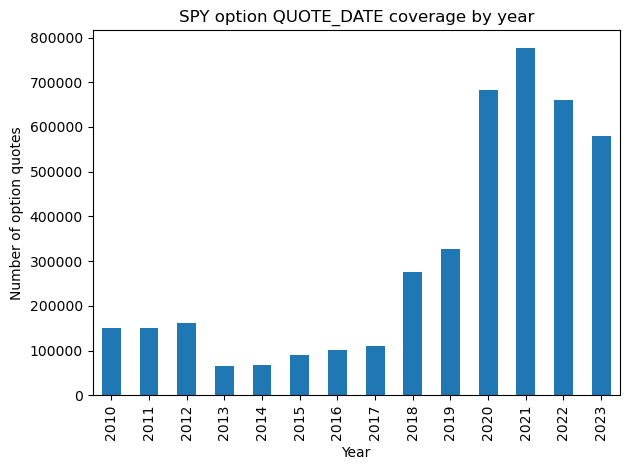

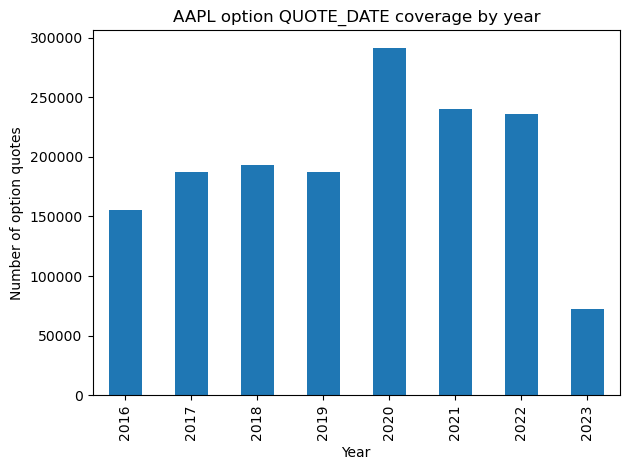

In [11]:
# ============================================================
# Quick side-by-side coverage audit (so you can SEE the gaps)
# ============================================================

import matplotlib.pyplot as plt

for asset in ["SPY", "AAPL"]:
    df = options_clean[asset]

    years = df["QUOTE_DATE"].dt.year.value_counts().sort_index()
    plt.figure()
    years.plot(kind="bar")
    plt.title(f"{asset} option QUOTE_DATE coverage by year")
    plt.xlabel("Year")
    plt.ylabel("Number of option quotes")
    plt.tight_layout()
    plt.show()